# Homework 2 - Berkeley STAT 157

Handout 1/29/2019, due 2/5/2019 by 4pm in Git by committing to your repository.

In [207]:
from mxnet import nd, autograd, gluon

## 1. Multinomial Sampling

Implement a sampler from a discrete distribution from scratch, mimicking the function `mxnet.ndarray.random.multinomial`. Its arguments should be a vector of probabilities $p$. You can assume that the probabilities are normalized, i.e. tha they sum up to $1$. Make the call signature as follows:

```
samples = sampler(probs, shape) 

probs   : An ndarray vector of size n of nonnegative numbers summing up to 1
shape   : A list of dimensions for the output
samples : Samples from probs with shape matching shape
```

Hints:

1. Use `mxnet.ndarray.random.uniform` to get a sample from $U[0,1]$.
1. You can simplify things for `probs` by computing the cumulative sum over `probs`.

In [208]:
def sampler(probs, shape):
    ## Add your codes here
    for i in range(1, len(probs)):
        probs[i] += probs[i-1]
    
    tmp = nd.random.uniform(0, 1, shape)
    result = nd.zeros(shape)
    for i in range(len(probs)):
        result += 1.0 * (tmp > probs[i])
    return result

# a simple test
sampler(nd.array([0.1, 0.2, 0.3, 0.2, 0.05, 0.15]), (9,20))


[[0. 5. 2. 2. 1. 3. 4. 3. 0. 2. 5. 1. 2. 2. 2. 2. 0. 2. 1. 4.]
 [2. 2. 5. 3. 0. 3. 5. 0. 5. 0. 2. 0. 2. 0. 1. 1. 3. 4. 0. 2.]
 [0. 2. 2. 3. 0. 2. 1. 0. 1. 2. 1. 3. 1. 2. 0. 2. 1. 5. 3. 1.]
 [0. 2. 0. 1. 0. 2. 1. 1. 5. 1. 2. 1. 2. 5. 4. 1. 1. 1. 1. 0.]
 [2. 2. 5. 2. 2. 2. 0. 4. 4. 1. 1. 3. 4. 3. 2. 2. 5. 3. 3. 2.]
 [2. 2. 1. 2. 0. 1. 1. 5. 0. 5. 1. 3. 1. 3. 3. 0. 2. 3. 0. 1.]
 [2. 2. 3. 1. 1. 5. 1. 2. 1. 5. 1. 1. 0. 0. 3. 0. 1. 1. 1. 2.]
 [0. 5. 1. 3. 1. 2. 1. 1. 2. 0. 2. 5. 4. 1. 5. 1. 0. 2. 1. 2.]
 [3. 1. 1. 1. 5. 4. 1. 3. 3. 0. 3. 3. 3. 1. 0. 4. 1. 2. 3. 0.]]
<NDArray 9x20 @cpu(0)>

# 2. Central Limit Theorem

Let's explore the Central Limit Theorem when applied to text processing. 

* Download [https://www.gutenberg.org/ebooks/84](https://www.gutenberg.org/files/84/84-0.txt) from Project Gutenberg 
* Remove punctuation, uppercase / lowercase, and split the text up into individual tokens (words).
* For the words `a`, `and`, `the`, `i`, `is` compute their respective counts as the book progresses, i.e. 
    $$n_\mathrm{the}[i] = \sum_{j = 1}^i \{w_j = \mathrm{the}\}$$
* Plot the proportions $n_\mathrm{word}[i] / i$ over the document in one plot.
* Find an envelope of the shape $O(1/\sqrt{i})$ for each of these five words.
* Why can we **not** apply the Central Limit Theorem directly? 
* How would we have to change the text for it to apply? 
* Why does it still work quite well?

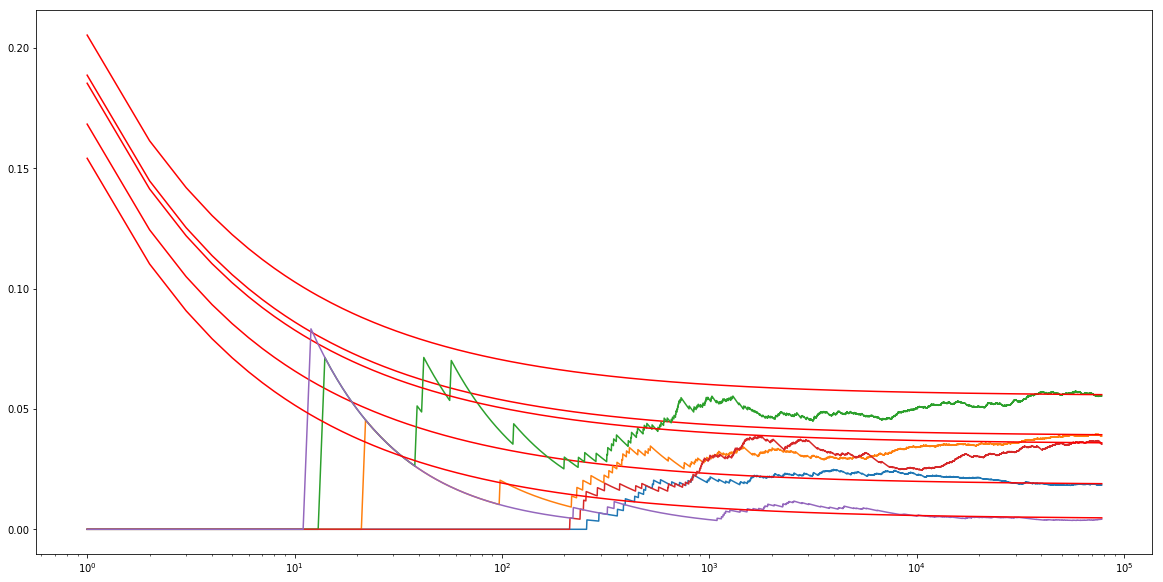

In [209]:
import string
import numpy as np
from matplotlib import pyplot as plt

filename = gluon.utils.download('https://www.gutenberg.org/files/84/84-0.txt')
with open(filename) as f:
    book = f.read()
for c in string.punctuation:
    book = book.replace(c,"")
book = book.lower() ##convert all to lowercase
book = book.split()
words = len(book)
counts = [0,0,0,0,0]
for k in range(5):
    counts[k] = nd.zeros(words).asnumpy()
for i in range(words):
    if book[i] == "a":
        counts[0][i] = 1
        continue 
    if book[i] == "and":
        counts[1][i] = 1
        continue
    if book[i] == "the":
        counts[2][i] = 1
        continue
    if book[i] == "i":
        counts[3][i] = 1
        continue
    if book[i] == "is":
        counts[4][i] = 1
        continue
var = 0.15
x = np.arange(1, words+1)
for k in range(5):
    counts[k] = np.cumsum(counts[k])/x
    counts[k].reshape(words, 1)
plt.figure(figsize=(20, 10))
for k in range(5):
    plt.semilogx(x, counts[k])
    mean = counts[k][words - 1]
    plt.semilogx(x, var*np.power(x,-0.5) + mean, "r")
    
plt.show()

Q: Why can we not apply the Central Limit Theorem directly? 

A: CLT asks for a normalized sum of sufficiently many i.i.d random variables, but in this text, the words don't appear independantly from each other. Take "the" for example: whether "the" appears at one position is not independent from the ones near it (a "the the" phrase might never appear). 
   
Q: How would we have to change the text for it to apply?

A: Following up on the answer above, we can re-shuffle all the words in the text to make each word distribute more evenly, to reach the desired independance. 

Q: Why does it still work quite well?

A: Because the proportions are very small in mean and variance, and as the total number of words increse, the correlation between words tend to be trivial.

## 3. Denominator-layout notation

We used the numerator-layout notation for matrix calculus in class, now let's examine the denominator-layout notation.

Given $x, y\in\mathbb R$, $\mathbf x\in\mathbb R^n$ and $\mathbf y \in \mathbb R^m$, we have

$$
\frac{\partial y}{\partial \mathbf{x}}=\begin{bmatrix}
\frac{\partial y}{\partial x_1}\\
\frac{\partial y}{\partial x_2}\\
\vdots\\
\frac{\partial y}{\partial x_n}
\end{bmatrix},\quad 
\frac{\partial \mathbf y}{\partial {x}}=\begin{bmatrix}
\frac{\partial y_1}{\partial x}, 
\frac{\partial y_2}{\partial x}, 
\ldots,
\frac{\partial y_m}{\partial x}
\end{bmatrix}
$$

and 

$$
\frac{\partial \mathbf y}{\partial \mathbf{x}}
=\begin{bmatrix}
\frac{\partial \mathbf y}{\partial {x_1}}\\
\frac{\partial \mathbf y}{\partial {x_2}}\\
\vdots\\
\frac{\partial \mathbf y}{\partial {x_3}}\\
\end{bmatrix}
=\begin{bmatrix}
\frac{\partial y_1}{\partial x_1}, 
\frac{\partial y_2}{\partial x_1},
\ldots,
\frac{\partial y_m}{\partial x_1}
\\ 
\frac{\partial y_1}{\partial x_2},
\frac{\partial y_2}{\partial x_2},
\ldots,
\frac{\partial y_m}{\partial x_2}\\ 
\vdots\\
\frac{\partial y_1}{\partial x_n},
\frac{\partial y_2}{\partial x_n},
\ldots,
\frac{\partial y_m}{\partial x_n}
\end{bmatrix}
$$

Questions: 

1. Assume $\mathbf  y = f(\mathbf u)$ and $\mathbf u = g(\mathbf x)$, write down the chain rule for $\frac {\partial\mathbf  y}{\partial\mathbf x}$

A: for the $ji$th entry in the resulting matrix: 
$$\frac {\partial(y_i)}{\partial(x_j)} = \frac {\partial(y_i)}{\partial(u_i)}*\frac {\partial(g_j)}{\partial(x_j)}$$

2. Given $\mathbf X \in \mathbb R^{m\times n},\ \mathbf w \in \mathbb R^n, \ \mathbf y \in \mathbb R^m$, assume $z = \| \mathbf X \mathbf w - \mathbf y\|^2$, compute $\frac{\partial z}{\partial\mathbf w}$.

Write out expression for $z$ with entries in $X, W, y$: 
$$z = (\Sigma_{i=1}^n x_{1i}w_i - y_1)^2 + ... + (\Sigma_{i=1}^n x_{mi}w_i - y_1)^2$$
$$\frac{\partial z}{\partial w_1} = 2(\Sigma_{i=1}^n x_{1i}w_1 - y_1)(x_{11})+...+2(\Sigma_{i=1}^n x_{mi}w_i - y_1)(x_{m1}) $$
Thus for $k = 1, ... n$
$$\frac{\partial z}{\partial w_k} = 2(\Sigma_{i=1}^n x_{1i}w_1 - y_1)(x_{1k})+...+2(\Sigma_{i=1}^n x_{mi}w_i - y_1)(x_{mk}) $$

## 4. Numerical Precision

Given scalars `x` and `y`, implement the following `log_exp` function such that it returns a numerically stable version of 
$$-\log\left(\frac{e^x}{e^x+e^y}\right)$$

In [210]:
from math import exp, log
def log_exp(x, y):
    ## add your solution here
    first = nd.exp(x)+ nd.exp(y)
    first = nd.log(first)
    return first - x

Test your codes with normal inputs:

In [211]:
x, y = nd.array([2]), nd.array([3])
z = log_exp(x, y)
z


[1.3132617]
<NDArray 1 @cpu(0)>

Now implement a function to compute $\partial z/\partial x$ and $\partial z/\partial y$ with `autograd`

In [212]:
def grad(forward_func, x, y): 
    ## Add your codes here
    x.attach_grad()
    with autograd.record():
        z = forward_func(x, y)
    z.backward()
    print('x.grad =', x.grad)
    y.attach_grad()
    with autograd.record():
        z = forward_func(x, y)
    z.backward()
    print('y.grad =', y.grad)

Test your codes, it should print the results nicely. 

In [213]:
grad(log_exp, x, y)

x.grad = 
[-0.7310586]
<NDArray 1 @cpu(0)>
y.grad = 
[0.7310586]
<NDArray 1 @cpu(0)>


But now let's try some "hard" inputs

In [214]:
x, y = nd.array([50]), nd.array([100])
grad(log_exp, x, y)
print(exp(100))
print(exp(50))

x.grad = 
[-1.]
<NDArray 1 @cpu(0)>
y.grad = 
[nan]
<NDArray 1 @cpu(0)>
2.6881171418161356e+43
5.184705528587072e+21


Does your code return correct results? If not, try to understand the reason. (Hint, evaluate `exp(100)`). Now develop a new function `stable_log_exp` that is identical to `log_exp` in math, but returns a more numerical stable result.

In [215]:
def stable_log_exp(x, y):
    ## Add your codes here
    inside = nd.exp(y-x) + 1
    return nd.log(inside)

grad(stable_log_exp, x, y)

x.grad = 
[-1.]
<NDArray 1 @cpu(0)>
y.grad = 
[1.]
<NDArray 1 @cpu(0)>
